 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8080
Press CTRL+C to quit


[[[  2  28  12]
  [  3  29  13]
  [  3  28  14]
  ...
  [ 41  90  92]
  [ 30  83  86]
  [ 26  83  85]]

 [[  1  27  11]
  [  1  27  11]
  [  1  26  12]
  ...
  [ 40  89  91]
  [ 30  83  86]
  [ 27  84  86]]

 [[  2  25  11]
  [  2  25  11]
  [  2  25  11]
  ...
  [ 43  92  94]
  [ 33  86  89]
  [ 30  87  89]]

 ...

 [[ 25 109  91]
  [ 19 105  87]
  [ 17 101  83]
  ...
  [ 27 111  93]
  [ 32 117  97]
  [ 50 135 115]]

 [[ 32 114  96]
  [ 22 106  88]
  [ 16  98  80]
  ...
  [ 25 110  90]
  [ 35 117  98]
  [ 48 130 111]]

 [[ 21 103  85]
  [ 13  95  77]
  [ 16  98  80]
  ...
  [ 25 110  90]
  [ 38 120 101]
  [ 48 130 111]]]


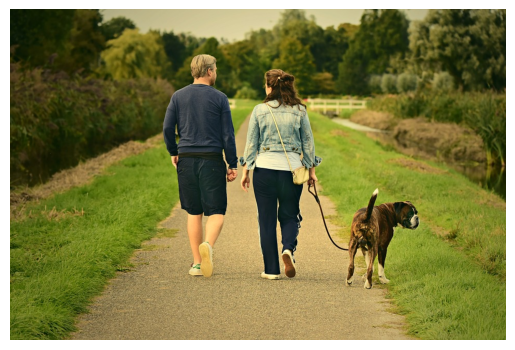

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


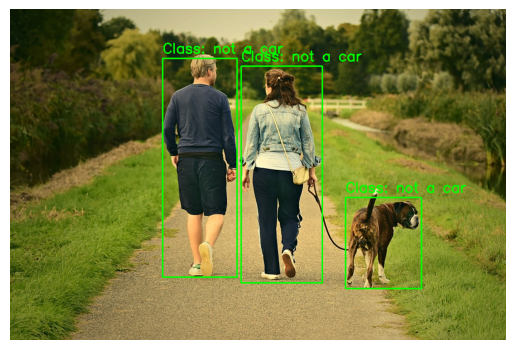

0


127.0.0.1 - - [03/Jun/2023 14:13:49] "POST /u HTTP/1.1" 200 -


[[[100  75  25]
  [159 130  73]
  [158 127  52]
  ...
  [ 41  39  38]
  [ 36  34  33]
  [ 40  38  37]]

 [[101  79  31]
  [146 121  65]
  [151 119  46]
  ...
  [ 32  33  31]
  [ 42  43  41]
  [ 27  28  26]]

 [[104  87  44]
  [139 117  65]
  [146 116  43]
  ...
  [ 33  37  32]
  [ 36  40  35]
  [ 26  30  25]]

 ...

 [[ 41  49  72]
  [ 42  50  73]
  [ 43  51  74]
  ...
  [ 48  67 104]
  [ 48  68 103]
  [ 48  67 104]]

 [[ 44  52  75]
  [ 45  53  76]
  [ 44  52  75]
  ...
  [ 47  66 104]
  [ 48  67 104]
  [ 48  67 105]]

 [[ 44  52  75]
  [ 44  52  75]
  [ 44  52  75]
  ...
  [ 45  64 102]
  [ 46  65 103]
  [ 47  66 104]]]


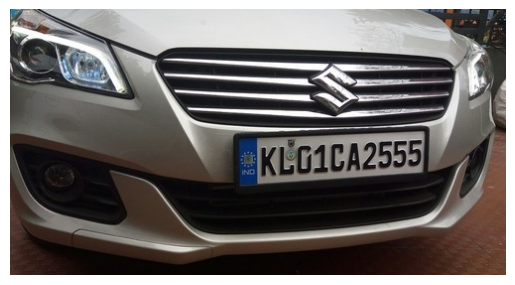

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


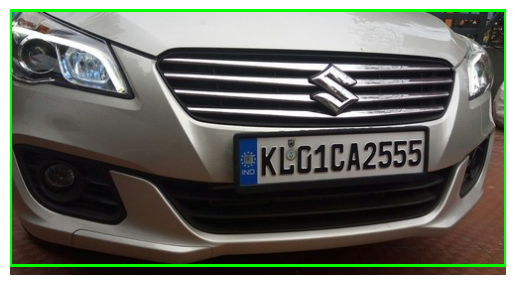

1


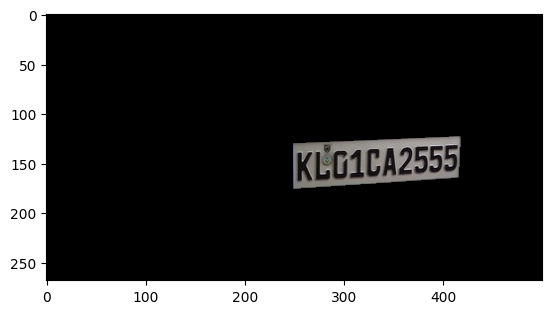

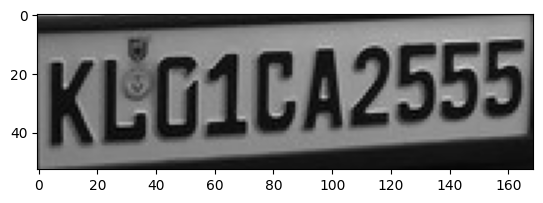

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


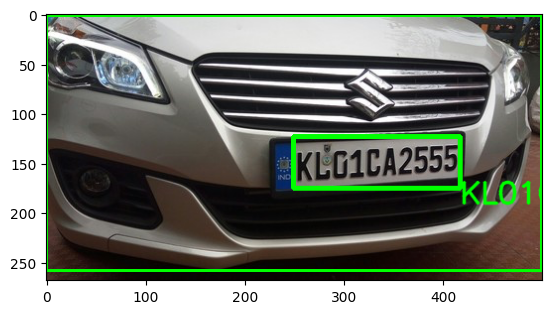

KL01CA2555


127.0.0.1 - - [03/Jun/2023 14:14:49] "POST /u HTTP/1.1" 200 -


In [1]:
from flask import Flask, request
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd 
import imutils
import easyocr
from flask import Flask, render_template, request


app = Flask(__name__,)


# @app.route('/')
# def upload_form():
#     return render_template('index.html')


ALLOWED_EXTENSIONS = {'jpg', 'jpeg','png'}

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/u', methods=['POST'])
def upload():
    # Check if an image file was submitted
    if 'image' not in request.files:
        return 'No image file found', 400

    image_file = request.files['image']

    # Check if the file has a valid filename and extension
    if image_file.filename == '' or not allowed_file(image_file.filename):
        return 'Invalid image file', 400

    # Read the uploaded image using OpenCV and transform it to a NumPy array
    image = cv2.imdecode(np.frombuffer(image_file.read(), np.uint8), cv2.IMREAD_COLOR)


    # Load the image
    def show_image(image):
        # Convert BGR to RGB color format
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        print(image)
        # Display the image
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
    def load_detectionmodel(path):
        model = tf.saved_model.load(path)
        return model
    
    def detect_car(model,image):
        # Get the model's input and output signatures
        infer = model.signatures['serving_default']

        # Load and preprocess the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.expand_dims(image, axis=0).astype(np.uint8)

        # Convert the input image to a tensor
        input_tensor = tf.convert_to_tensor(image)

        # Run the inference
        detections = infer(input_tensor)
        return detections
    def show_detections(detections):
        class_mapping = {3: 'car'}
                
        # Extract the bounding boxes, labels, and scores
        boxes = detections['detection_boxes'][0].numpy()
        classes = detections['detection_classes'][0].numpy().astype(np.int32)
        scores = detections['detection_scores'][0].numpy()

        # Set a threshold for the detection scores
        score_threshold = 0.5

        # Iterate over the detections and draw bounding boxes
        flag=0
        for i in range(len(scores)):
            if scores[i] > score_threshold:
                ymin, xmin, ymax, xmax = boxes[i]
                ymin = int(ymin * image.shape[0])
                xmin = int(xmin * image.shape[1])
                ymax = int(ymax * image.shape[0])
                xmax = int(xmax * image.shape[1])
                
                class_number = classes[i]
                class_name = class_mapping.get(class_number, 'not a car')  # Get class name from mapping, default to 'Unknown' if not found

                label = f'Class: {class_name}'
                cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                if class_number == 3:
                    flag=1
        

        # Display the image with detections
        plt.imshow( cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        return flag
    show_image(image)
    model=load_detectionmodel(r'D:\yasser\iti courses\21-computer vision\car plate ocr\models\ssd_mobilenet_v2_coco_2018_03_29.tar\ssd_mobilenet_v2_coco_2018_03_29\saved_model')
    detection=detect_car(model,image)
    show_detection=show_detections(detection)
    print(show_detection)
    if show_detection:
        def detect_plate(image):
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
            edged = cv2.Canny(bfilter, 30, 200) #Edge detection
            keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contourss = imutils.grab_contours(keypoints)
            contours = sorted(contourss, key=cv2.contourArea, reverse=True)[:10]
            #print(contours)
            len(contours)
            location = None
            for contour in contours:
                approx = cv2.approxPolyDP(contour, 10, True)
                if len(approx) == 4:
                    location = approx
                    break
            len(location) 
            mask = np.zeros(gray.shape, np.uint8)
            new_image = cv2.drawContours(mask, [location], -1,255, -1)
            new_image = cv2.bitwise_and(image, image, mask=mask)   
            plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
            plt.show()

            (x,y) = np.where(mask==255)
            (x1, y1) = (np.min(x), np.min(y))
            (x2, y2) = (np.max(x), np.max(y))
            cropped_image = gray[x1:x2+1, y1:y2+1]
            plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
            plt.show()
            reader = easyocr.Reader(['en'])
            result = reader.readtext(cropped_image)
            result
            text = result[0][-2]
            font = cv2.FONT_HERSHEY_SIMPLEX
            res = cv2.putText(image, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
            res = cv2.rectangle(image, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
            plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
            plt.show()

            print(text)
            return text
            
        text=detect_plate(image)
    else :
        text="there is no car"
        return text

    




 

 

    # Return a success response
    return text, 200

if __name__ == '__main__':
    app.run(port=8080)
